```
From: https://github.com/ksatola
Version: 0.1.0
```

# Binary Classification Template

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../src')

In [4]:
from datasets import (
    get_dataset
)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import pandas as pd
import pandas_profiling

from sklearn import (
    ensemble,
    model_selection,    
    preprocessing,
    tree,
)

from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)

from sklearn.experimental import (
    enable_iterative_imputer,
)

from sklearn import impute

from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC,
)

from yellowbrick.model_selection import (
    LearningCurve,
)

/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Business Understanding: Problem Statement
Based on Titanic passenger characteristics predict if they survive or not (binary classification).

## Data Understanding: Dataset

Independent variables:
- pclass - Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd)
- name - Name
- sex - Sex
- age - Age
- sibsp - Number of siblings/spouses aboard
- parch - Number of parents/children aboard
- ticket - Ticket number
- fare - Passenger fare
- cabin - Cabin
- embarked - Point of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
- boat - Lifeboat
- body - Body identification number
- home.dest - Home/destination

Dependent variable:
- survival - Survival (0 = No, 1 = Yes)

In [6]:
df = get_dataset('titanic3')
orig_df = df

In [7]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Data Preparation
- Check if data is numerical (only some models allow categorical data) and encode it if needed
    - Check data types (convert data types to proper ones if needed)
- Check if there are missing values
- Try normalizing data (normalization or standardization)
- Check if there are leaking data (containing information about the target/outcome)

In [8]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [9]:
df.shape

(1309, 14)

### Data Profiling

In [10]:
pandas_profiling.ProfileReport(df)

In [11]:
df.describe().iloc[:, :2]

,pclass,survived
count,1309.000000,1309.000000
mean,2.294882,0.381971
std,0.837836,0.486055
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,3.000000,1.000000
max,3.000000,1.000000


In [12]:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

Columns boat and body contain `leaked data`. Boat informs if someone survived and body (identifier) if someone died. Columns cabin, boat and body should be removed.

In [13]:
# Show rows with missing data (in any column)
mask = df.isnull().any(axis=1)
mask.head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [14]:
df[mask].body.head()

0      NaN
1      NaN
2      NaN
3    135.0
4      NaN
Name: body, dtype: float64

In [15]:
# Show how many observations we have per column
df[mask].count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

In [8]:
# Show percent of missing values per column
df.isnull().mean() * 100

pclass        0.000000
survived      0.000000
name          0.000000
sex           0.000000
age          20.091673
sibsp         0.000000
parch         0.000000
ticket        0.000000
fare          0.076394
cabin        77.463713
embarked      0.152788
boat         62.872422
body         90.756303
home.dest    43.086325
dtype: float64

In [17]:
# Count unique values for categorical columns
df.sex.value_counts(dropna=False)

male      843
female    466
Name: sex, dtype: int64

In [18]:
df.embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

In [19]:
# Get the counts of missing features for each sample
df.isnull().sum(axis=1).loc[:10]

0     1
1     1
2     2
3     1
4     2
5     1
6     1
7     2
8     1
9     2
10    1
dtype: int64

In [9]:
# Show percent of missing values per row
df.isnull().mean(axis=1).head() * 100

0     7.142857
1     7.142857
2    14.285714
3     7.142857
4    14.285714
dtype: float64

### Define features for modeling
- We can drop columns where variance or std. deviation is equal 0 (no signal)
- We can drop text columns where each observation has different value (if this is no NLP problem)
- We can drop columns that leak information

In [21]:
columns = ['name', 'ticket', 'home.dest', 'boat', 'body', 'cabin']
df = df.drop(columns=columns)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


In [22]:
# Create dummy columns from string columns
df = pd.get_dummies(df)
df.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,1,0,0,0,1
1,1,1,0.9167,1,2,151.5500,0,1,0,0,1
2,1,0,2.0000,1,2,151.5500,1,0,0,0,1
3,1,0,30.0000,1,2,151.5500,0,1,0,0,1
4,1,0,25.0000,1,2,151.5500,1,0,0,0,1


At this point the sex_male and sex_female columns are perfectly `inverse correlated`. Typically we remove any columns with perfect or very high positive or negative correlation. `Multicollinearity` can impact interpretation of feature importance and coefficients in some models.

In [23]:
df = df.drop(columns="sex_male")
# or if we use
#df = pd.get_dummies(df, drop_first=True) 
# we already have this done by get_dummies()

In [24]:
y = df.survived
X = df.drop(columns='survived')

### Train-test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [26]:
X_train.head()

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
306,1,54.0,0,1,77.2875,0,0,0,1
927,3,NaN,1,0,14.4542,0,1,0,0
642,3,13.0,4,2,31.3875,0,0,0,1
1294,3,28.5,0,0,16.1000,0,0,0,1
1015,3,55.5,0,0,8.0500,0,0,0,1


In [27]:
y_train.head()

306     0
927     0
642     0
1294    0
1015    0
Name: survived, dtype: int64

### Data Imputation

The age column has missing values. We need to impute age from the numeric values. `We only want to impute on the training set and then use that imputer to fill in the date for the test set`. Otherwise we are leaking data (cheating by giving future information to the model). Now that we have test and train data, we can impute missing values on the training set, and use the trained imputers to fill in the test dataset.

In [28]:
num_cols = [
    "pclass",
    "age",
    "sibsp",
    "parch",
    "fare",
    "sex_female",
]

In [29]:
imputer = impute.IterativeImputer()
imputed = imputer.fit_transform(X_train[num_cols])

In [30]:
imputed[1] # new row 1 values in X_train

array([ 3.        , 24.27089623,  1.        ,  0.        , 14.4542    ,
        0.        ])

In [31]:
X_train.loc[:, num_cols] = imputed

/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [32]:
imputed = imputer.transform(X_test[num_cols])
X_test.loc[:, num_cols] = imputed

/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


### Impute with Median
Alternatively but take it only from X_train

In [33]:
#meds = X_train.median()
#X_train = X_train.fillna(meds)
#X_test = X_test.fillna(meds)

### Normalize Data
Normalizing or preprocessing the data will help many models perform better after this is done. Particularly those that depend on a distance metric to determine similarity. (Note that tree models, which treat each feature on its own, don’t have this requirement.) `Standardizing` is translating the data so that it has a mean value of zero and a standard deviation of one. This way models don’t treat variables with larger scales as more important than smaller scaled variables.

`Normalization` usually means to scale a variable to have a values between 0 and 1, while `standardization` transforms data to have a mean of zero and a standard deviation of 1.

In [34]:
# Normally don’t standardize dummy columns
cols = "pclass,age,sibsp,fare".split(",")

In [35]:
sca = preprocessing.StandardScaler()
X_train = sca.fit_transform(X_train[cols])
X_train = pd.DataFrame(X_train, columns=cols)

In [36]:
X_train.head()

,pclass,age,sibsp,fare
0,-1.543720,1.863610,-0.487688,0.906108
1,0.834829,-0.378656,0.525287,-0.366368
2,0.834829,-1.228744,3.564212,-0.023441
3,0.834829,-0.059683,-0.487688,-0.333038
4,0.834829,1.976745,-0.487688,-0.496063


In [37]:
X_test = sca.transform(X_test[cols])
X_test = pd.DataFrame(X_test, columns=cols)

### Refactor
Gather everything needed into reusable functions

In [38]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

In [39]:
def get_train_test_X_y(df, y_col, size=0.3, std_cols=None):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=size, random_state=42)
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    X_train.loc[:, num_cols] = fi.fit_transform(X_train[num_cols])
    X_test.loc[:, num_cols] = fi.transform(X_test[num_cols])

    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[:, std_cols] = std.fit_transform(X_train[std_cols])
        X_test.loc[:, std_cols] = std.transform(X_test[std_cols])
    
    return X_train, X_test, y_train, y_test

In [40]:
ti_df = tweak_titanic(orig_df)

std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, "survived", std_cols=std_cols)

/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [41]:
ti_df.head()

,pclass,survived,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,0,0,1
1,1,1,0.9167,1,2,151.5500,1,0,1
2,1,0,2.0000,1,2,151.5500,0,0,1
3,1,0,30.0000,1,2,151.5500,1,0,1
4,1,0,25.0000,1,2,151.5500,0,0,1


## Modeling

### Baseline Model
Creating a `baseline model` that does something really simple can give us something to compare our model to. Note that using the default `.score` result gives us the accuracy which can be misleading. 

In [42]:
from sklearn.dummy import DummyClassifier
bm = DummyClassifier()
bm.fit(X_train, y_train)
bm.score(X_test, y_test)  # accuracy

/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


0.5241730279898219

In [43]:
from sklearn import metrics
metrics.precision_score(y_test, bm.predict(X_test))

0.4807692307692308

### Find Best Algorithm
No algorithm performs well on all data. However, for some finite set of data, there may be an algorithm that does well on that set.

Here we use a few different families and compare the `AUC (Area Under the ROC Curve)` score and `standard deviation` using k-fold cross-validation. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0. An algorithm that has a slightly smaller average score but tighter standard deviation might be a better choice.

Because we are using k-fold cross-validation, we will feed the model all of X and y.

In [44]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [45]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

#### For imbalanced CV with Oversampling and with pipeline example see: Cross Validation notebook (8110)

In [46]:
for model in [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier,
]:
    
    cls = model()
    kfold = model_selection.KFold(n_splits=10, random_state=4)
    s = model_selection.cross_val_score(cls, X, y, scoring="roc_auc", cv=kfold)

    print(f"{model.__name__:22}  AUC: "
          f"{s.mean():.3f} STD: {s.std():.2f}")

/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of str

DummyClassifier         AUC: 0.498 STD: 0.04
LogisticRegression      AUC: 0.843 STD: 0.03
DecisionTreeClassifier  AUC: 0.765 STD: 0.03
KNeighborsClassifier    AUC: 0.830 STD: 0.05
GaussianNB              AUC: 0.817 STD: 0.04
SVC                     AUC: 0.837 STD: 0.05


/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


RandomForestClassifier  AUC: 0.844 STD: 0.03


/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


XGBClassifier           AUC: 0.859 STD: 0.03


### Stacking
If you want maximum performance at the cost of interpretability, stacking is an option. A `stacking classifier` takes other models and uses their output to predict a target or label. We will use the previous models’ outputs and combine them to see if a stacking classifier can do better.

In [47]:
from mlxtend.classifier import StackingClassifier

In [48]:
clfs = [
    x()
    for x in [
        LogisticRegression,
        DecisionTreeClassifier,
        KNeighborsClassifier,
        GaussianNB,
        SVC,
        RandomForestClassifier,
        xgboost.XGBClassifier,
    ]
]

In [49]:
stack = StackingClassifier(
    classifiers=clfs,
    meta_classifier=LogisticRegression(),
)

In [50]:
kfold = model_selection.KFold(n_splits=10, random_state=42)

/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [51]:
s = model_selection.cross_val_score(stack, X, y, scoring="roc_auc", cv=kfold)

In [52]:
print(
    f"{stack.__class__.__name__}  "
    f"AUC: {s.mean():.3f}  STD: {s.std():.2f}"
)

StackingClassifier  AUC: 0.791  STD: 0.04


### Create Model
The best seems to be XGBClassifier. We will train it (calling `.fit`) with the training data from the data that we split earlier into a training and testing set.

Then we can use the test data to see how well the model generalizes to data that it hasn’t seen before. The `.score` method of a classifier returns the average of the prediction accuracy.

A nice benefit of tree-based models is that you can inspect the `feature importance`. The feature importance tells you how much a feature contributes to the model. Note that removing a feature doesn’t mean that the score will go down accordingly, as other features might be `colinear` (in this case we could remove either the sex_male or sex_female column as they have a perfect negative correlation). The `feature importance` is calculated by looking at the error increase. If removing a feature increases the error in the model, the feature is more important. With black-box models the `SHAP library` can be used for exploring what features a model deems important, and for explaining predictions.

In [53]:
m = xgboost.XGBClassifier(random_state=42)
m.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
# Accuracy
m.score(X_test, y_test)

0.8015267175572519

In [55]:
# Precision
metrics.precision_score(y_test, m.predict(X_test))

0.8095238095238095

In [56]:
# Feature Importance
for col, val in sorted(zip(X_train.columns, m.feature_importances_,), key=lambda x: x[1], reverse=True,)[:5]:
    print(f"{col:10}{val:10.3f}")

sex_male       0.539
pclass         0.252
sibsp          0.057
fare           0.038
age            0.034


### Optimize Model
Models have `hyperparameters` that control how they behave. By varying the values for these parameters, we change their performance.

In [57]:
%%time
mt = xgboost.XGBClassifier()

# https://xgboost.readthedocs.io/en/latest/parameter.html
params = {
    # Parameters that we are going to tune.
    'max_depth': [0, 1, 2, 4, 6, 8, 10],
    'min_child_weight': [0, 1, 2, 4, 8],
    'eta': [.1, .3, .5], # learning rate
    'subsample': [.5, 1],
    'colsample_bytree': [.5, 1],
    # Other parameters
    'objective': ['binary:logistic', 'binary:logitraw'],
}

cv = model_selection.GridSearchCV(mt, params, n_jobs=-1).fit(X_train, y_train)

print(cv.best_params_)

{'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 6, 'min_child_weight': 4, 'objective': 'binary:logistic', 'subsample': 1}
CPU times: user 6.11 s, sys: 210 ms, total: 6.32 s
Wall time: 9.1 s


In [ ]:
n_jobs=1
{'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 6, 'min_child_weight': 4, 'objective': 'binary:logistic', 'subsample': 1}
CPU times: user 2h 6min 51s, sys: 1min 41s, total: 2h 8min 33s
Wall time: 5min 22s

n_jobs=-1
{'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 6, 'min_child_weight': 4, 'objective': 'binary:logistic', 'subsample': 1}
CPU times: user 19.7 s, sys: 892 ms, total: 20.6 s
Wall time: 10.6 s

### Model

In [59]:
m_final = xgboost.XGBClassifier(
    **{
        'colsample_bytree': 0.5, 
        'eta': 0.1, 
        'max_depth': 6, 
        'min_child_weight': 4, 
        'objective': 'binary:logistic', 
        'subsample': 1}
)
m_final.fit(X_train, y_train)
m_final.score(X_test, y_test)

0.7938931297709924

## Evaluation

### Confusion Matrix
A `confusion matrix` allows us to see the correct classifications as well as `false positives` and `false negatives`. It may be that we want to optimize toward false positives or false negatives, and different models or parameters can alter that.

This is a useful evaluation tool that presents the predicted class along the bottom and the true class along the side. A good classifier would have all of the values along the diagonal, and zeros in the other cells.

In [60]:
from sklearn.metrics import confusion_matrix

y_pred = m_final.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[204,  20],
       [ 61, 108]])

/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/yellowbrick/classifier/base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


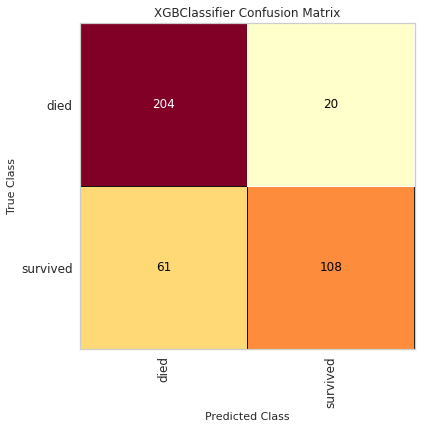

In [61]:
mapping = {0: "died", 1: "survived"}

fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(m_final, classes=["died", "survived"], label_encoder=mapping,)
cm_viz.score(X_test, y_test)
cm_viz.poof()
fig.savefig("images/classification_binary_conf_matrix.png", dpi=300, bbox_inches="tight",)

### ROC Curve
A `Receiver Operating Characteristic (ROC)` plot is a common tool used to evaluate classifiers. By measuring the `Area Under the Curve (AUC)`, we can get a metric to compare different classifiers. It plots the true positive rate against the false positive rate. In general, the further it bulges out the better. Measuring the AUC gives a single number to evaluate. Closer to one is better. Below .5 is a poor model.

In [62]:
y_pred = m_final.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7748837700760779

/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/yellowbrick/classifier/base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


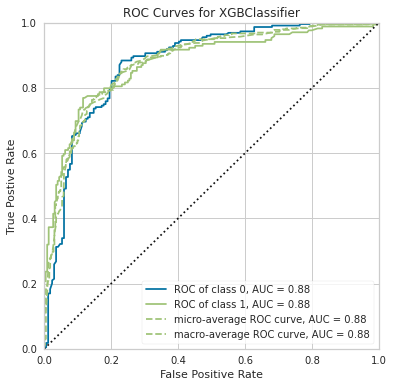

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(m_final)
roc_viz.score(X_test, y_test)
roc_viz.show()
fig.savefig("images/classification_binary_roc.png")

### Learning Curve
A `learning curve` is used to tell us if we have enough training data. It trains the model with increasing portions of the data and measures the score. If the cross-validation score continues to climb, then we might need to invest in gathering more data.

/home/ksatola/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


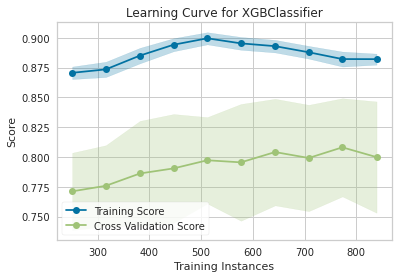

In [64]:
fig, ax = plt.subplots(figsize=(6, 4))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)

lc_viz = LearningCurve(
    m_final,
    cv=cv,
    train_sizes=sizes,
    scoring="f1_weighted",
    n_jobs=4,
    ax=ax,
)
lc_viz.fit(X_train, y_train)
lc_viz.show()
fig.savefig("images/classification_binary_learning_curve.png")

## Deployment
Using Python’s `pickle` module, we can persist models and load them. Once we have a model, we call the `.predict` method to get a classification or regression result.

In [65]:
import pickle

# Serialize the model
pic = pickle.dumps(m_final)

In [66]:
# Read model
m_final2 = pickle.loads(pic)
y_pred = m_final2.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7748837700760779